# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



## TODO (To be deleted)

create a dictionary for a colour palette \
translate entries \
find the most controversial topic types between parties \
find the most controversial questions between parties

do pca and t-sne

apply clustering algorithms

do analysis on elected candidates

Use people that are not in a party to see in which party they would fit based on the questions they had provided.

Imports 

In [416]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Reshaping the data

In [417]:
def scatter_plot(data, x_column, y_column):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=data[x_column], y=data[y_column], hue='parti', palette=party_colors)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f'{x_column} vs {y_column}')
    plt.show()

In [418]:
df = pd.read_excel("alldata.xlsx")
df.columns

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'navn', 'parti', '1a', '1b', '2a',
       '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a',
       '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b', 'storkreds',
       'alder'],
      dtype='object')

In [419]:
# We need to rename the columns to combine these two dataframes

drq = pd.read_excel("drq.xlsx")
print(drq.columns)
tv2q = pd.read_excel("tv2q.xlsx")
print(tv2q.columns)

Index(['ID', 'Title', 'Question', 'Info', 'ArgumentFor', 'ArgumentAgainst',
       'WordMerger', 'ID_CandidateQuestionType', 'Rule', 'QuestionListData'],
      dtype='object')
Index(['id', 'type', 'header', 'question', 'depends'], dtype='object')


In [420]:
# The tv2's 'type' doesn't tell us anything as it only has one value
print(tv2q['type'].unique(), "\n")
# Therefore we'll merge the Titles and headers
print(drq['Title'].unique())
print(tv2q['header'].unique())

['rate'] 

['KLIMA OG ENERGI' 'ARBEJDSMARKED OG ØKONOMI' 'RET OG STRAF'
 'EU OG UDENRIGS' 'VELFÆRD' 'UDDANNELSE' 'DEMOKRATI' 'SUNDHED']
['Bornholms Storkreds' 'Fyns Storkreds' 'Københavns Omegns Storkreds'
 'Københavns Storkreds' 'Nordjyllands Storkreds' 'Nordsjællands Storkreds'
 'Sjællands Storkreds' 'Sydjyllands Storkreds' 'Vestjyllands Storkreds'
 'Østjyllands Storkreds' 'Miljø og klima' 'Hospitaler og sundhed'
 'Udenrigs- og forsvarspolitik' 'Økonomi' 'Ældre'
 'Flygtninge og indvandrere' 'Energipolitik' 'Børn og unge'
 'Skole og uddannelse' 'Socialområdet' 'Mink-sagen' 'Coronavirus']


In [421]:
# Renaming columns
drq.rename(columns={
    "ID": "id",
    "Title": "header",
    "Question": "question"
}, inplace=True)

# Dropping unnecessary columns
drq.drop(columns=['Info', 'ArgumentFor', 'ArgumentAgainst', 
          'WordMerger', 'ID_CandidateQuestionType', 'Rule', 'QuestionListData'], inplace=True)

tv2q.drop(columns=['type', 'depends'], inplace=True)

In [422]:
questions = pd.concat([drq, tv2q])

In [423]:
danish_headers = ['KLIMA OG ENERGI', 'ARBEJDSMARKED OG ØKONOMI', 'RET OG STRAF', 'EU OG UDENRIGS', 'VELFÆRD', 'UDDANNELSE', 'DEMOKRATI', 'SUNDHED', 'Bornholms Storkreds', 'Fyns Storkreds', 'Københavns Omegns Storkreds', 'Københavns Storkreds', 'Nordjyllands Storkreds', 'Nordsjællands Storkreds', 'Sjællands Storkreds', 'Sydjyllands Storkreds', 'Vestjyllands Storkreds', 'Østjyllands Storkreds', 'Miljø og klima', 'Hospitaler og sundhed', 'Udenrigs- og forsvarspolitik', 'Økonomi', 'Ældre', 'Flygtninge og indvandrere', 'Energipolitik', 'Børn og unge', 'Skole og uddannelse', 'Socialområdet', 'Mink-sagen', 'Coronavirus']
english_headers = ['CLIMATE AND ENERGY', 'LABOR MARKET AND ECONOMY', 'JUSTICE AND PUNISHMENT', 'EU AND FOREIGN AFFAIRS', 'WELFARE', 'EDUCATION', 'DEMOCRACY', 'HEALTH', 'Bornholm Greater Constituency', 'Funen Greater Constituency', 'Copenhagen Greater Constituency', 'Copenhagen Greater Constituency', 'Northern Jutland Greater Constituency', 'North Zealand Greater Constituency', 'Zealand Greater Constituency', 'Southern Jutland Greater Constituency', 'West Jutland Greater Constituency', 'Eastern Jutland Greater Constituency', 'Environment and Climate', 'Hospitals and Health', 'Foreign and Defense Policy', 'Economy', 'Elderly', 'Refugees and Immigrants', 'Energy Policy', 'Children and Youth', 'School and Education', 'Social Affairs', 'Mink Case', 'Coronavirus']

header_mapping = {}

for index in range(len(danish_headers)):
    header_mapping[danish_headers[index]] = english_headers[index]

questions['header_eng'] = questions['header'].map(header_mapping)

In [424]:
len(questions.question.unique())

97

In [425]:
df.drop(columns=['storkreds', 'alder'], inplace=True)

In [426]:
df['parti'].unique()

array(['Moderaterne', 'Socialistisk Folkeparti', 'Alternativet',
       'Løsgænger', 'Enhedslisten', 'Danmarksdemokraterne', 'Venstre',
       'Frie Grønne, Danmarks Nye Venstrefløjsparti', 'Dansk Folkeparti',
       'Kristendemokraterne', 'Liberal Alliance', 'Nye Borgerlige',
       'Det Konservative Folkeparti', 'Radikale Venstre',
       'Socialdemokratiet'], dtype=object)

In [427]:
danish_parties = [
    "Moderaterne",
    "Socialistisk Folkeparti",
    "Alternativet",
    "Løsgænger",
    "Enhedslisten",
    "Danmarksdemokraterne",
    "Venstre",
    "Frie Grønne, Danmarks Nye Venstrefløjsparti",
    "Dansk Folkeparti",
    "Kristendemokraterne",
    "Liberal Alliance",
    "Nye Borgerlige",
    "Det Konservative Folkeparti",
    "Radikale Venstre",
    "Socialdemokratiet",
]
english_parties = [
    "The Moderates",
    "Socialist People's Party",
    "The Alternative",
    "Independent",
    "The Red–Green Alliance",
    "Danish Democrats",
    "Leftists",
    "Free Greens, Denmark's New Left Wing Party",
    "Danish People's Party",
    "Christian Democrats",
    "Liberal Alliance",
    "New Bourgeois",
    "The Conservative People's Party",
    "Radical Left",
    "Social Democracy",
]

parti_mapping = {}

for index in range(len(danish_parties)):
    parti_mapping[danish_parties[index]] = english_parties[index]

df["parti_english"] = df["parti"].map(parti_mapping)

In [428]:
# Dictionary of colors based on the party name
party_colors = {
    'Social Democracy': '#B32723',
    'Leftists': '#006697',
    'The Moderates': '#6C3AE5',
    "Socialist People's Party": '#DD0778',
    'Danish Democrats': '#8AC3FF',
    'Liberal Alliance': '#20C6CF',
    "The Conservative People's Party": '#9DBA27',
    'The Red–Green Alliance': '#ED801A',
    'Radical Left': '#713380',
    'New Bourgeois': '#054F5C',
    'The Alternative': '#2B8F39',
    "Danish People's Party": '#F3CD41',
    "Free Greens, Denmark's New Left Wing Party": '#01E66A',
    'Christian Democrats': '#BABABA',
    'Independent': '#000000',
}

df['color'] = df['parti'].map(party_colors)

# Corelation Matrix

In [429]:
df.columns

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'navn', 'parti', '1a', '1b', '2a',
       '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a',
       '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b',
       'parti_english', 'color'],
      dtype='object')

/var/folders/md/j2f882mn1vl7cb0f7l2mmkjh0000gp/T/ipykernel_86574/3793908898.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr().abs()


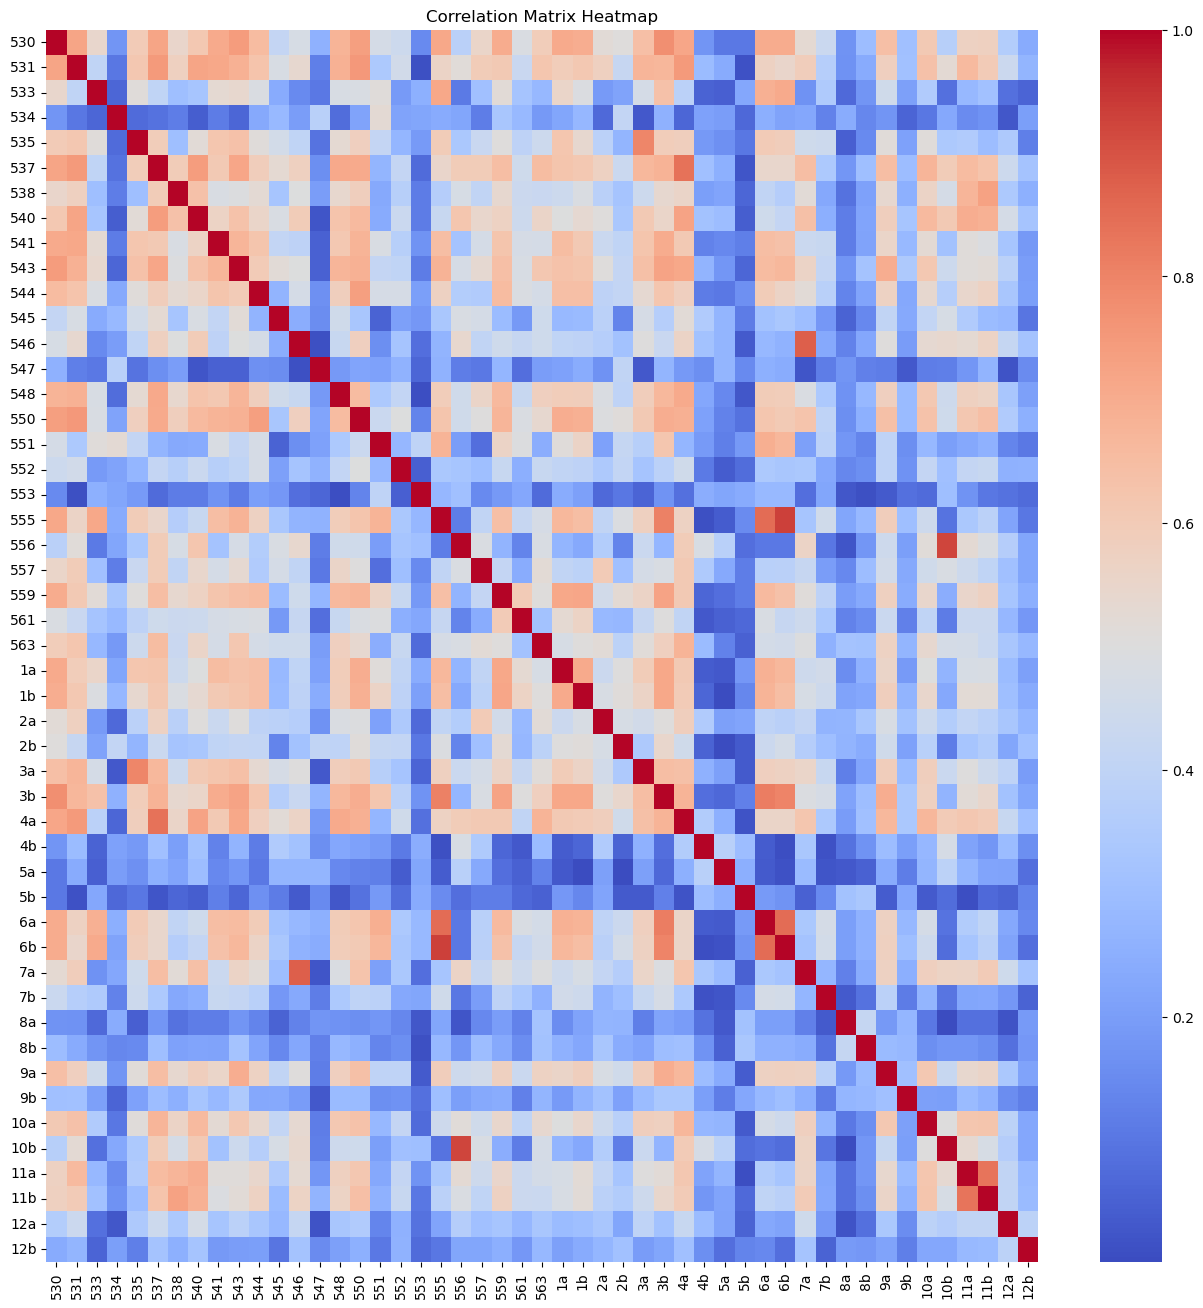

In [430]:
correlation_matrix = df.corr().abs()

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [431]:
# Find features that have a high correlation with other features (we're going to drop these features)

threshold = 0.8
high_corr_pairs = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_pairs.add(colname)

high_corr_pairs

{'10b', '11b', '3b', '4a', '6a', '6b', '7a'}

In [432]:
df.drop(columns=high_corr_pairs, inplace=True)

## PCA

In [433]:
index = 0
mapping = {}
for parti in df['parti'].unique():
    mapping[parti] = index
    index += 1

df['parti_number'] = df['parti'].map(mapping)

In [434]:
correlations = df.corr(numeric_only=True)['parti_number'].drop('parti_number')
print(len(correlations[abs(correlations) < 0.3]))
print(len(correlations[abs(correlations) > 0.3]))

28
14


In [435]:
relevant_questions = correlations[abs(correlations) > 0.25].index

In [436]:
X = df[relevant_questions]

In [437]:
X.columns

Index(['530', '531', '533', '535', '537', '540', '541', '543', '544', '545',
       '548', '550', '555', '557', '563', '1a', '1b', '2a', '3a', '7b'],
      dtype='object')

In [438]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

In [439]:
pca.explained_variance_ratio_

array([0.57097286, 0.07657399])

In [440]:
df['pca_1'] = pca_results[:, 0]
df['pca_2'] = pca_results[:, 1]

In [441]:
df.parti_english.unique()

array(['The Moderates', "Socialist People's Party", 'The Alternative',
       'Independent', 'The Red–Green Alliance', 'Danish Democrats',
       'Leftists', "Free Greens, Denmark's New Left Wing Party",
       "Danish People's Party", 'Christian Democrats', 'Liberal Alliance',
       'New Bourgeois', "The Conservative People's Party", 'Radical Left',
       'Social Democracy'], dtype=object)

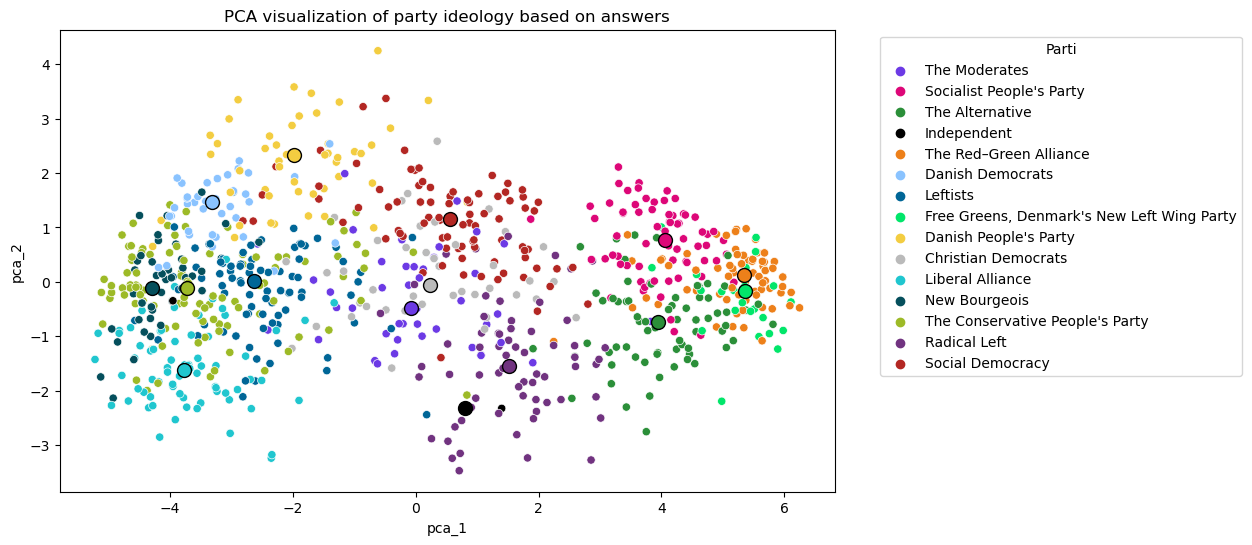

In [442]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='parti_english', data=df, palette=party_colors)
for party, color in party_colors.items():
    party_center = df[df['parti_english'] == party][['pca_1', 'pca_2']].median()
    plt.scatter(party_center['pca_1'], party_center['pca_2'], color=color, s=100, edgecolor='black')
plt.legend(party_colors)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Parti')
plt.title('PCA visualization of party ideology based on answers')
plt.show()

## t-SNE

In [443]:
tsne = TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(data_scaled)
rot = PCA(n_components=2)
X_tsne = rot.fit_transform(X_tsne)

In [444]:
df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]

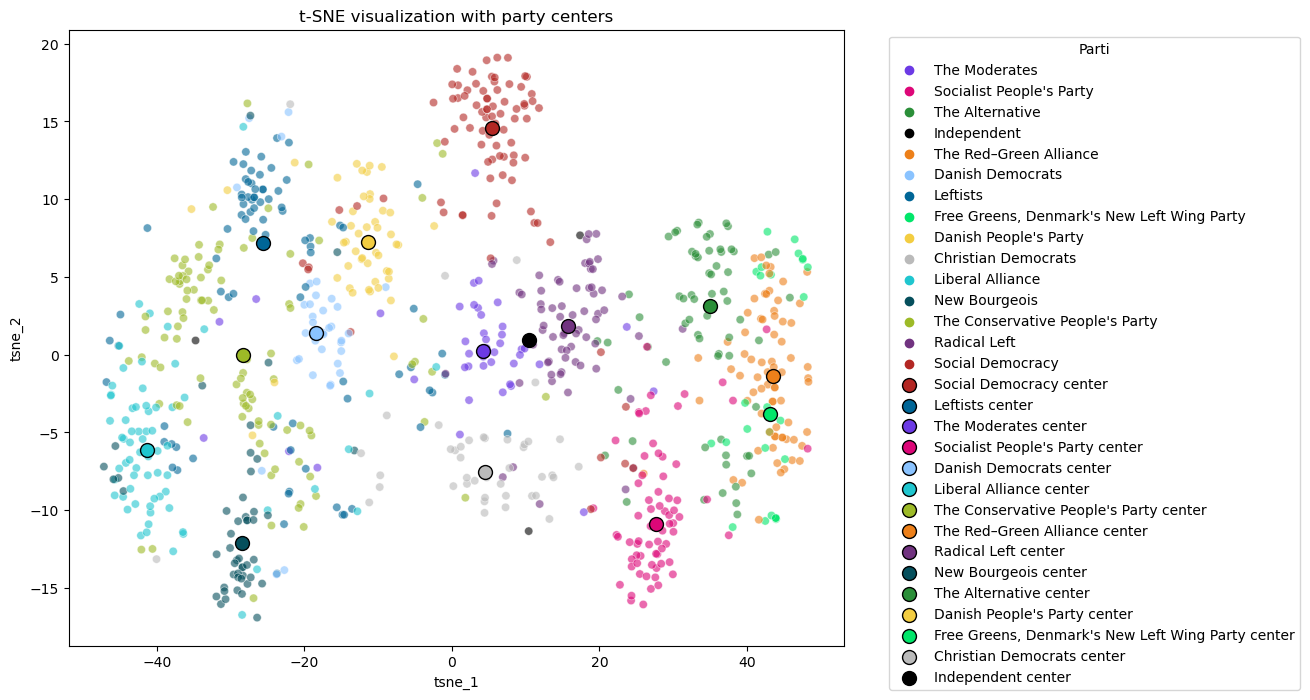

In [445]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='parti_english', data=df, palette=party_colors, alpha=0.6)
for party, color in party_colors.items():
    party_center = df[df['parti_english'] == party][['tsne_1', 'tsne_2']].median()
    plt.scatter(party_center['tsne_1'], party_center['tsne_2'], color=color, s=100, edgecolor='black', label=f'{party} center')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Parti')
plt.title('t-SNE visualization with party centers')
plt.show()

## K-Means

In [446]:
k_cluster = KMeans(n_clusters=15, n_init=100, random_state=42, init='k-means++')
k_res = k_cluster.fit_predict(data_scaled)

In [447]:
centers = k_cluster.cluster_centers_

In [448]:
temp = df.copy()

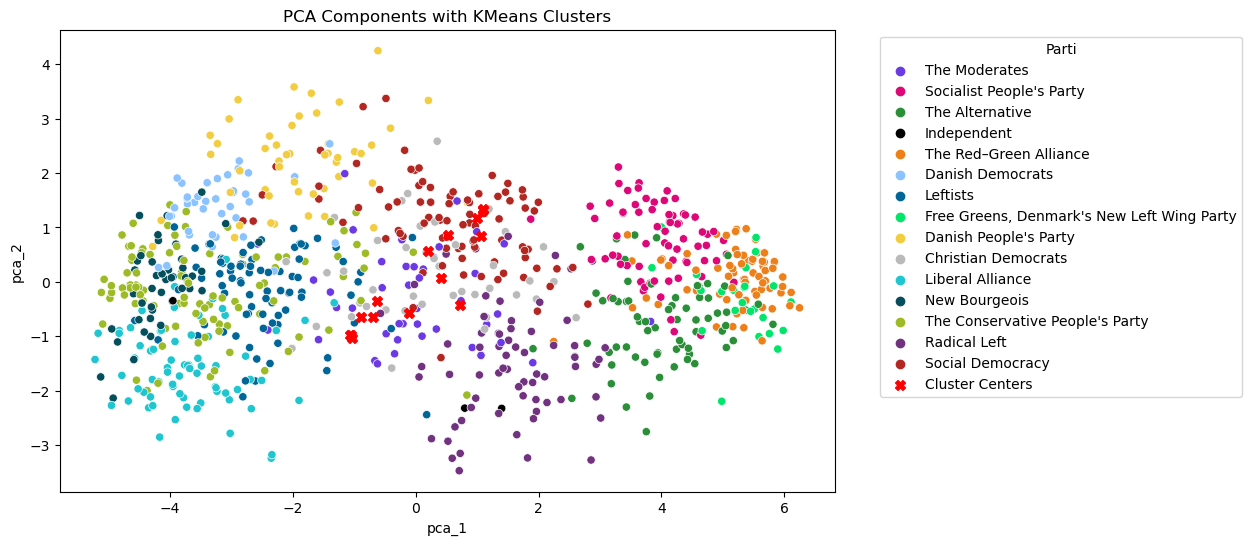

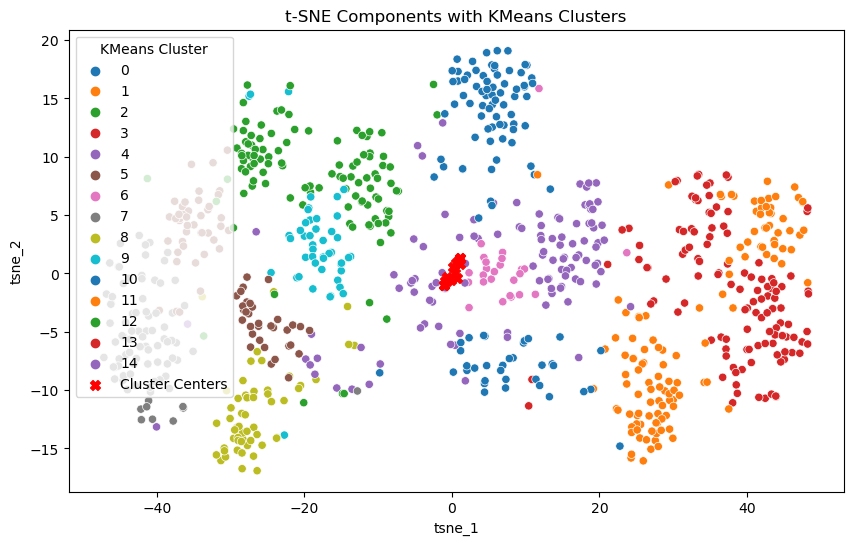

In [451]:
# Add the KMeans cluster labels to the dataframe
temp['kmeans_cluster'] = k_res

# Create scatter plots to visualize the clusters in relation to the party data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='parti_english', data=df, palette=party_colors)
plt.scatter(centers[:, 0], centers[:, 1], s=50, c='red', label='Cluster Centers', marker='X')
plt.title('PCA Components with KMeans Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Parti')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='kmeans_cluster', palette='tab10', data=temp)
plt.scatter(centers[:, 0], centers[:, 1], s=50, c='red', label='Cluster Centers', marker='X')
plt.title('t-SNE Components with KMeans Clusters')
plt.legend(title='KMeans Cluster')
plt.show()


## Hierarchical clustering

## DBSCAN

# Elected candidate analysis

In [452]:
elected = pd.read_excel("electeddata.xlsx")
elected.shape

(169, 53)

In [453]:
print("The average age of an elected:", elected['alder'].mean())
print("The median age of an elected:", elected['alder'].median())

The average age of an elected: 45.0
The median age of an elected: 46.0


In [454]:
questions_overview = df.describe().T.reset_index(names='id')
questions_overview = pd.merge(left=questions_overview, right=questions, on='id')

In [455]:
# We can see that most controversial questions for elected candidates 
# were surrounding the mink case and refugees and immigrants

questions_overview.sort_values(by='std', ascending=False).head(10)

,id,count,mean,std,min,25%,50%,75%,max,header,question,header_eng
14,11a,867.0,-0.725490,1.474442,-2.0,-2.0,-1.0,1.0,2.0,Mink-sagen,Der har været alt for meget fokus på Mette Fre...,Mink Case
0,1a,867.0,-0.412918,1.454536,-2.0,-2.0,-1.0,1.0,2.0,Miljø og klima,"Oksekød bør pålægges en klimaafgift, således a...",Environment and Climate
3,2b,867.0,0.291811,1.438971,-2.0,-1.0,1.0,1.5,2.0,Hospitaler og sundhed,Cigaretter bør pålægges en ekstra afgift på 20...,Hospitals and Health
4,3a,867.0,0.685121,1.411368,-2.0,0.0,1.0,2.0,2.0,Udenrigs- og forsvarspolitik,Danmark bør bruge to procent af BNP på forsvar...,Foreign and Defense Policy
11,9a,867.0,-0.340254,1.410381,-2.0,-2.0,-1.0,1.0,2.0,Skole og uddannelse,Dele af SU’en på videregående uddannelser skal...,School and Education
1,1b,867.0,0.377163,1.368428,-2.0,-1.0,1.0,2.0,2.0,Miljø og klima,"De virksomheder, der udleder mest CO₂, skal be...",Environment and Climate
13,10a,867.0,0.490196,1.235851,-2.0,-1.0,1.0,1.0,2.0,Socialområdet,Det offentlige bruger i dag for mange penge på...,Social Affairs
16,12b,867.0,-0.422145,1.222147,-2.0,-2.0,0.0,0.0,2.0,Coronavirus,"Hvis coronasmitten stiger markant til vinter, ...",Coronavirus
5,4b,867.0,0.565167,1.187438,-2.0,0.0,1.0,1.0,2.0,Økonomi,Staten bør i højere grad kompensere danskerne ...,Economy
2,2a,867.0,0.843137,1.152699,-2.0,0.0,1.0,2.0,2.0,Hospitaler og sundhed,Folketinget bør afsætte midler målrettet et lø...,Hospitals and Health


In [456]:
# Confirming the previous point by taking standard deviation
questions_overview.groupby(['header_eng']).mean(numeric_only=True).sort_values(by='std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
header_eng,,,,,,,,
Mink Case,867.0,-0.725490,1.474442,-2.0,-2.0,-1.0,1.00,2.0
Environment and Climate,867.0,-0.017878,1.411482,-2.0,-1.5,0.0,1.50,2.0
Foreign and Defense Policy,867.0,0.685121,1.411368,-2.0,0.0,1.0,2.00,2.0
Hospitals and Health,867.0,0.567474,1.295835,-2.0,-0.5,1.0,1.75,2.0
Social Affairs,867.0,0.490196,1.235851,-2.0,-1.0,1.0,1.00,2.0
School and Education,867.0,-0.188005,1.212041,-2.0,-1.5,-0.5,1.00,2.0
Economy,867.0,0.565167,1.187438,-2.0,0.0,1.0,1.00,2.0
Coronavirus,867.0,0.117647,1.125097,-2.0,-1.0,0.5,0.50,2.0
Energy Policy,867.0,0.837370,1.100110,-2.0,0.0,1.0,2.00,2.0


In [457]:
grouped = elected.groupby(['parti']).mean(numeric_only=True).describe().T.drop(index=['alder']).reset_index(names='id')

In [458]:
# Similary to the overall controversy, the most disagreed topics are refugees, 
# the mink case, and foreign and defence policy

grouped.sort_values(by='std', ascending=False).merge(questions, on='id')

,id,count,mean,std,min,25%,50%,75%,max,header,question,header_eng
0,6b,12.0,0.068202,1.620414,-2.000000,-1.803571,0.978261,1.166667,2.000000,Flygtninge og indvandrere,Det vil være en god idé at etablere et dansk a...,Refugees and Immigrants
1,11b,12.0,0.595994,1.617337,-1.916667,-1.218254,1.278571,1.916925,2.000000,Mink-sagen,"Det bør undersøges, om Mette Frederiksen kan s...",Mink Case
2,3b,12.0,-0.267058,1.611655,-2.000000,-1.628571,-0.775362,1.660714,1.888889,Udenrigs- og forsvarspolitik,Ulandsbistanden bør hæves.,Foreign and Defense Policy
3,6a,12.0,-0.328275,1.502263,-2.000000,-1.658333,-0.694940,1.203571,1.888889,Flygtninge og indvandrere,Den danske udlændingepolitik er for stram.,Refugees and Immigrants
4,10b,12.0,0.644119,1.477261,-1.928571,0.040373,1.100000,1.877232,2.000000,Socialområdet,"Den såkaldte Arne-pension, der giver mulighed ...",Social Affairs
5,7a,12.0,-0.322823,1.470259,-1.928571,-1.578571,-0.628571,0.839286,2.000000,Energipolitik,Indførelse af atomkraft i Danmark vil være et ...,Energy Policy
6,9a,12.0,-0.124833,1.410865,-1.928571,-1.628571,0.062112,1.110714,1.600000,Skole og uddannelse,Dele af SU’en på videregående uddannelser skal...,School and Education
7,1b,12.0,0.116994,1.332953,-2.000000,-0.628571,-0.017081,1.273810,2.000000,Miljø og klima,"De virksomheder, der udleder mest CO₂, skal be...",Environment and Climate
8,3a,12.0,0.760426,1.289372,-1.800000,0.479911,1.250000,1.600000,2.000000,Udenrigs- og forsvarspolitik,Danmark bør bruge to procent af BNP på forsvar...,Foreign and Defense Policy
9,11a,12.0,-0.784867,1.274248,-2.000000,-1.934783,-1.100000,0.233333,1.604167,Mink-sagen,Der har været alt for meget fokus på Mette Fre...,Mink Case
